In [1]:
# THIS SCRIPT HAS TWO MAIN FUNCTIONS:
# (1) TO COMBINE .nc FILES OF CHOICE INTO A SINGLE .nc FILE WHICH WILL BE USED FOR A TRAIN/VAL SPLIT
# (2) TO SPLIT THE COMBINED .nc FILE INTO A TRAINING .nc FILE AND A VALIDATION .nc FILE
#     (2.1) this has a few benefits: we can (hopefully) easily convert the .nc files back into .tif files, to visualize in QGIS

In [2]:
%reset -f

In [15]:
#############################################
# import relevant packages and dependencies
#############################################

# typical stuff:
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import psutil
import os
import sys
import pyproj
import random

# dask-related stuff:
from dask.diagnostics import ProgressBar

# geo-related stuff
# from osgeo import gdal, osr
from shapely.geometry import box
import tifffile
import geopandas as gpd
from PIL import Image
import rasterio
from rasterio.windows import Window
from rasterio.warp import transform

# tensorflow-related stuff
import torch
from torch.utils.data import TensorDataset, DataLoader



In [5]:
#######################################
# COMBINES .nc DATASETS INTO ONE DATASET USING DASK
# NOTE: THIS ALSO CONVERTS IMAGE TO float32 AND NORMALIZES
#######################################

### list of .nc files to combine: ###
ncfiles_north = ['~/data/data/QB02_20120729152314.nc','~/data/data/QB02_20120731154958.nc','~/data/data/QB02_20120731155001.nc',
                 '~/data/data/QB02_20120731155004.nc','~/data/data/WV01_20120713164417.nc','~/data/data/WV01_20120713164418.nc',
                 '~/data/data/WV01_20120713164419.nc','~/data/data/WV01_20120803164853.nc','~/data/data/WV01_20120803164854.nc',
                 '~/data/data/WV01_20120803164855.nc','~/data/data/WV01_20120803164856.nc']

ncfiles_south = ['~/data/data/WV01_20120713005151.nc','~/data/data/WV01_20120713005152.nc','~/data/data/WV01_20120713005153.nc',
                '~/data/data/WV01_20120802153813.nc','~/data/data/WV01_20120802153814.nc','~/data/data/WV01_20120802153815.nc',
                '~/data/data/WV01_20120802153816.nc','~/data/data/WV01_20120802153817.nc']

ncfiles_combo_example = ['~/data/data/QB02_20120729152314.nc','~/data/data/QB02_20120731154958.nc','~/data/data/QB02_20120731155001.nc',
                 '~/data/data/QB02_20120731155004.nc','~/data/data/WV01_20120713164417.nc','~/data/data/WV01_20120802153815.nc',
                '~/data/data/WV01_20120802153816.nc','~/data/data/WV01_20120802153817.nc']

ncfiles_combo_small_example = ['~/data/data/QB02_20120729152314.nc','~/data/data/QB02_20120731154958.nc','~/data/data/QB02_20120731155001.nc',
                 '~/data/data/QB02_20120731155004.nc','~/data/data/WV01_20120713005151.nc','~/data/data/WV01_20120713005152.nc','~/data/data/WV01_20120713005153.nc']
# south .nc files are about 30GB total, north .nc files are about 50GB total when combined and converted to float32 type

#### functions: ###

def convert_variables_to_float32(dataset, variable_names):
    """
    Convert specified variables in the dataset to float32.
    Args:
        dataset (xarray.Dataset): The dataset to modify.
        variable_names (list of str): List of variable names to convert.   
    Returns:
        xarray.Dataset: The modified dataset with specified variables converted to float32.
    """
    for variable_name in variable_names:
        if variable_name in dataset:
            if variable_name=='image_data':
                dataset[variable_name] = dataset[variable_name].astype('float32') / 255.0  
            else:
                dataset[variable_name] = dataset[variable_name].astype('float32') 
    return dataset

def combine_nc_files(ncfiles, ncfile_combined_path, chunks=None):
    '''
    Combine specified group of .nc files into one single .nc file and convert underlying variables to to float32
    Args:
        ncfiles: list of .nc file names
        ncfile_combined_path: path for the combined .nc file
        chunks: how you want to chunk this using Dask
    '''
    # (optional) Enable Dask by specifying chunking; choose an appropriate size 
    # chunks = {'tiles': 3000}  # chunk size

    # Specify the variable names to convert
    # variable_names_to_convert = ['image_data', 'label_data']
    variable_names_to_convert = ['image_data']

    # Load datasets with chunks and convert the specified variables
    datasets = [convert_variables_to_float32(xr.open_dataset(f, chunks=chunks), variable_names_to_convert) for f in ncfiles]

    # Concatenate the datasets along the 'tiles' dimension
    combined_dataset = xr.concat(datasets, dim='tiles')
    
    # Save the combined dataset to a new .nc file using Dask to manage memory
    with ProgressBar():
        combined_dataset.to_netcdf(ncfile_combined_path, mode='w')
i
    # Close the combined dataset
    combined_dataset.close()
    
    
### CALL TO COMBINE THE NC FILES ###
combine_nc_files(ncfiles=["~/data/data/ncfile_north_south_example.nc", "data/data/custom_nc_files/ncfile_south_large_example_val.nc"], chunks={'tiles':3000}, ncfile_combined_path='~/data/data/ncfile_north_south_example_val.nc')  


[########################################] | 100% Completed | 50m 22ss


In [91]:
dataset = xr.open_dataset('data/data/orig_nc_files/WV01_20120802153816.nc')
print(dataset)

<xarray.Dataset> Size: 2GB
Dimensions:           (tiles: 12176, dim2: 294, dim1: 294)
Dimensions without coordinates: tiles, dim2, dim1
Data variables:
    id                (tiles) float64 97kB ...
    x                 (tiles) float64 97kB ...
    y                 (tiles) float64 97kB ...
    x_start           (tiles) float64 97kB ...
    x_stop            (tiles) float64 97kB ...
    y_start           (tiles) float64 97kB ...
    y_stop            (tiles) float64 97kB ...
    fracture_density  (tiles) float64 97kB ...
    image_data        (dim2, dim1, tiles) uint8 1GB ...
    label_data        (dim2, dim1, tiles) uint8 1GB ...
Attributes:
    Image:    WV01_20120802153816


Text(0.5, 1.0, 'Mask Image')

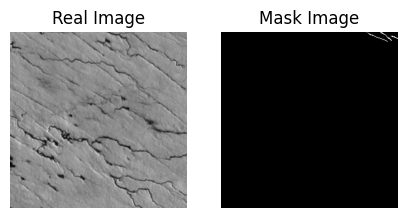

In [176]:
idx = random.randint(0,len(dataset['image_data'][:, :]))
plt.figure(figsize = (5, 10))
plt.subplot(1, 2, 1)
plt.imshow(dataset['image_data'][:,:,idx], cmap = 'gray')
plt.axis('off')
plt.title('Real Image')

plt.subplot(1, 2, 2)
plt.imshow(dataset['label_data'][:,:,idx],  cmap = 'gray')
plt.axis('off')
plt.title('Mask Image')

In [115]:
combine_nc_files(ncfiles=["data/data/custom_nc_files/ncfile_south_large_example_val.nc", chunks={'tiles':3000}, ncfile_combined_path='~/data/data/ncfile_north_south_val.nc')   

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (882372085.py, line 1)

In [2]:
########################################
# SPLIT A .nc DATASET INTO THREE (TRAIN/VAL/TEST)
########################################

def trainvaltest_split_ncfile(filepath_combined, filepath_train, filepath_val, filepath_test, train_split, val_split, chunks=None):
    # chunks = {'tiles': 10000}  # Example: chunking along the 'time' dimension
    dataset = xr.open_dataset(filepath_combined, chunks=chunks)

    # trainval_split = 0.8
    split_index = int(dataset.sizes['tiles'] * train_split)  # 80% for the training set
    split_index_2 = int(dataset.sizes['tiles'] * (train_split + val_split))

    subset_1 = dataset.isel(tiles=slice(None, split_index))
    subset_2 = dataset.isel(tiles=slice(split_index, split_index_2))
    subset_3 = dataset.isel(tiles=slice(split_index_2, None))
    
    print(dataset.sizes,subset_1.sizes, subset_2.sizes, subset_3.sizes)

    # Wrap the saving operations with ProgressBar
    print('creating training subset')
    with ProgressBar():
        subset_1.to_netcdf(filepath_train, mode='w')
    print('creating validation subset')
    with ProgressBar():
        subset_2.to_netcdf(filepath_val, mode='w')
    print('creating testing subset')
    with ProgressBar():
        subset_3.to_netcdf(filepath_test, mode='w')
        
        
### CALL TO SPLIT THE .nc FILE TO TRAIN AND VAL SETS ###
trainvaltest_split_ncfile(filepath_combined='~/data/data/ncfile_north_south_example.nc', filepath_train='~/data/data/ncfile_north_south_example_train.nc', filepath_val='~/data/data/ncfile_north_south_example_train.nc', filepath_test='~/data/data/ncfile_north_south_example_test.nc',
                          train_split=0.60, val_split = 0.2, chunks={'tiles': 10000})

Frozen({'tiles': 70538, 'dim2': 294, 'dim1': 294}) Frozen({'tiles': 42322, 'dim2': 294, 'dim1': 294}) Frozen({'tiles': 14108, 'dim2': 294, 'dim1': 294}) Frozen({'tiles': 14108, 'dim2': 294, 'dim1': 294})
creating training subset
[########################################] | 100% Completed | 23m 38s
creating validation subset
[########################################] | 100% Completed | 482.06 s
creating testing subset
[########################################] | 100% Completed | 455.84 s


In [ ]:
########################################
# SPLIT A .nc DATASET INTO TWO (TRAIN/VAL)
########################################

def trainval_split_ncfile(filepath_combined, filepath_train, filepath_val, trainval_split, chunks=None):
    # chunks = {'tiles': 10000}  # Example: chunking along the 'time' dimension
    dataset = xr.open_dataset(filepath_combined, chunks=chunks)

    # trainval_split = 0.8
    split_index = int(dataset.sizes['tiles'] * trainval_split)  # 80% for the training set

    subset_1 = dataset.isel(tiles=slice(None, split_index))
    subset_2 = dataset.isel(tiles=slice(split_index, None))

    # Wrap the saving operations with ProgressBar
    print('creating training subset')
    with ProgressBar():
        subset_1.to_netcdf(filepath_train, mode='w')
    print('creating validation subset')
    with ProgressBar():
        subset_2.to_netcdf(filepath_val, mode='w')
        
        
### CALL TO SPLIT THE .nc FILE TO TRAIN AND VAL SETS ###
trainval_split_ncfile(filepath_combined='~/data/data/ncfile_north_south_example.nc', filepath_train='~/data/data/ncfile_north_south_example_train.nc', filepath_val='~/data/data/ncfile_north_south_example_train.nc', trainval_split=0.8, chunks={'tiles': 10000})

In [3]:
import dask
from dask.diagnostics import ProgressBar

def creating_sample_train_val(filepath_combined, filepath_train, filepath_val, train_num, val_num, chunks = None):
    
    dataset = xr.open_dataset(filepath_combined, chunks=chunks)
    print(dataset)
    

    # Generate a random array of indices
    random_array = np.arange(dataset.sizes['tiles'])
    np.random.shuffle(random_array)
    # Calculate the split index
    
    # Define the trainval_split
    first_half = random_array[:train_num]
    first_half.sort()
    second_half = random_array[train_num:(train_num + val_num)]
    second_half.sort()
    
    print(first_half)
    print(second_half)
    
    #subset_1 = dataset.isel(tiles = slice(None, split_index))
    #subset_2 = dataset.isel(tiles = slice(split_index, None))
    
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        subset_1 = dataset.isel(tiles=first_half)
        subset_2 = dataset.isel(tiles=second_half)
        
    print(subset_1)
    print(subset_2)
    
    
    # Wrap the saving operations with ProgressBar
    print("creating training subset: ", filepath_train)
    with ProgressBar():
        subset_1.to_netcdf(filepath_train, mode='w')
    
    print("creating validation subset: ", filepath_val)
    with ProgressBar():
        subset_2.to_netcdf(filepath_val, mode='w')
    
        
### CALL TO SPLIT THE .nc FILE TO SMALL TRAIN AND VAL SETS ###
#creating_sample_train_val('~/custom_nc_files/ncfile_south_outside.nc', '~/custom_nc_files/ncfile_south_example_train.nc', '~/custom_nc_files/ncfile_south_outside_example_val.nc', 4000, 1000, chunks={'tiles': 10000})


<xarray.Dataset> Size: 34GB
Dimensions:           (tiles: 78857, dim2: 294, dim1: 294)
Dimensions without coordinates: tiles, dim2, dim1
Data variables:
    id                (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    x                 (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    y                 (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    x_start           (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    x_stop            (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    y_start           (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    y_stop            (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    fracture_density  (tiles) float64 631kB dask.array<chunksize=(10000,), meta=np.ndarray>
    image_data        (dim2, dim1, tiles) float32 27GB dask.array<chunksize=(294, 294, 10000), meta=np.ndarray>

In [3]:
import dask
from dask.diagnostics import ProgressBar

def creating_sample(filepath_combined, filepath, num, chunks = None):
    
    dataset = xr.open_dataset(filepath_combined, chunks=chunks)
    print(dataset)
    

    # Generate a random array of indices
    random_array = np.arange(dataset.sizes['tiles'])
    np.random.shuffle(random_array)
    # Calculate the split index
    
    # Define the trainval_split
    first_half = random_array[:num]
    first_half.sort()
    
    print(first_half)
    
    #subset_1 = dataset.isel(tiles = slice(None, split_index))
    #subset_2 = dataset.isel(tiles = slice(split_index, None))
    
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        subset_1 = dataset.isel(tiles=first_half)
        
    print(subset_1)
    
    
    # Wrap the saving operations with ProgressBar
    print("creating training subset: ", filepath)
    with ProgressBar():
        subset_1.to_netcdf(filepath, mode='w')
    
        
### CALL TO SPLIT THE .nc FILE TO SMALL TRAIN AND VAL SETS ###
creating_sample('~/data/data/custom_nc_files/ncfile_north_outside.nc', '~/data/data/ncfile_north_outside_small_example.nc', 4000, chunks={'tiles': 10000})

<xarray.Dataset> Size: 43GB
Dimensions:           (tiles: 98481, dim2: 294, dim1: 294)
Dimensions without coordinates: tiles, dim2, dim1
Data variables:
    id                (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    x                 (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    y                 (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    x_start           (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    x_stop            (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    y_start           (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    y_stop            (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    fracture_density  (tiles) float64 788kB dask.array<chunksize=(10000,), meta=np.ndarray>
    image_data        (dim2, dim1, tiles) float32 34GB dask.array<chunksize=(294, 294, 10000), meta=np.ndarray>

In [1]:
creating_sample_train_val('~/custom_nc_files/ncfile_south_outside.nc', '~/custom_nc_files/ncfile_south_small_train.nc', '~/custom_nc_files/ncfile_south_small_val.nc', 4000, 1000, chunks={'tiles': 10000})

NameError: name 'creating_sample_train_val' is not defined